# Прогноз оттока клиентов Телеком-компании

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# **Описание данных**

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

# **Цель и задачи**

**Цель работы:** построить модель, которая с высокой эффективностью (ROC-AUC > 0.85) сможет предсказать уйдёт ли клиент в ближайшее время или нет.

**Задачи:**
1. Составить план работы.
2. Познакомиться с данными и проверить их качество.
3. Провести разведочный анализ данных.
4. Подготовить данные для обучения моделей.
5. Разработать несколько моделей машинного обучения.
6. Проанализировать полученные модели и выбрать лучшую
7. Составить отчет по проделанной работе.

In [ ]:
!pip install phik
!pip install catboost
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import time

from phik.report import plot_correlation_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

RS = 310723

In [ ]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

## Знакомство с данными

In [ ]:
df_list = [contract, personal, internet, phone]
for df in df_list:
    display(df.sample())
    print(df.shape)
    print(df.nunique())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6113,1228-ZLNBX,2018-05-01,No,Month-to-month,No,Mailed check,75.3,1739.43


(7043, 8)
customerID          7043
BeginDate             77
EndDate               67
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658
dtype: int64


,customerID,gender,SeniorCitizen,Partner,Dependents
6189,4718-WXBGI,Male,0,Yes,Yes


(7043, 5)
customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5426,5996-EBTKM,DSL,No,No,Yes,Yes,No,Yes


(5517, 8)
customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64


,customerID,MultipleLines
468,6825-UYPFK,Yes


(6361, 2)
customerID       6361
MultipleLines       2
dtype: int64


Предоставленные файлы разных размеров, при этом стобец `customerID` содержит только уникальные значения.
В такой ситуации стоит ожидать появления пропусков после слияния таблиц. Во всех датасетах есть общий столбец `customerID` -  слили таблицы по этому столбцу:

In [ ]:
def df_merge(df1, df2):
    return df1.merge(df2, on='customerID', how='outer')

df = df_merge(contract, personal)
df = df_merge(df, internet)
df = df_merge(df, phone)

display(df.sample())
print(df.shape)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
679,2826-UWHIS,2016-05-01,No,Month-to-month,No,Bank transfer (automatic),81.4,3663.0,Male,0,Yes,No,Fiber optic,No,Yes,No,No,No,No,Yes


(7043, 20)


Явно выделили целевой признак на основе столбца `EndDate`:

In [ ]:
df['IsChurn'] = df['EndDate'] != 'No'
df['IsChurn'] = df['IsChurn'].astype('int')
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,IsChurn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


Познакомились с данными поближе:
- Посмотрели на уникальные значения в каждом столбце
- Вывели графики распределения данных в категориальных столбцах
- Построили гистограммы и диаграммы размаха для количественных признаков

In [ ]:
display(df.info())
display(df.describe())
print('\nКоличество пропусков:\n', df.isna().sum())
print('\nКоличество дубликатов:\n', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

,MonthlyCharges,SeniorCitizen,IsChurn
count,7043.000000,7043.000000,7043.000000
mean,64.761692,0.162147,0.156325
std,30.090047,0.368612,0.363189
min,18.250000,0.000000,0.000000
25%,35.500000,0.000000,0.000000
50%,70.350000,0.000000,0.000000
75%,89.850000,0.000000,0.000000
max,118.750000,1.000000,1.000000



Количество пропусков:
 customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
IsChurn                0
dtype: int64

Количество дубликатов:
 0


In [ ]:
num_feat = ['MonthlyCharges', 'TotalCharges']
dates = ['BeginDate', 'EndDate']
cat_feat = []
for col in df.columns:
    if col not in num_feat and col not in dates and col != 'customerID':
        cat_feat.append(str(col))
        print(col, df[col].unique(), '\n')
for col in dates:
    print(col, sorted(df[col].unique()), '\n')

Type ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling ['Yes' 'No'] 

PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

gender ['Female' 'Male'] 

SeniorCitizen [0 1] 

Partner ['Yes' 'No'] 

Dependents ['No' 'Yes'] 

InternetService ['DSL' 'Fiber optic' nan] 

OnlineSecurity ['No' 'Yes' nan] 

OnlineBackup ['Yes' 'No' nan] 

DeviceProtection ['No' 'Yes' nan] 

TechSupport ['No' 'Yes' nan] 

StreamingTV ['No' 'Yes' nan] 

StreamingMovies ['No' 'Yes' nan] 

MultipleLines [nan 'No' 'Yes'] 

IsChurn [0 1] 

BeginDate ['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-

### Категориальные признаки

In [ ]:
def plot_cat_feat(col):
    plt.rcParams['font.size'] = '20'
    values = col.value_counts()
    labels = values.index.astype('str')
    plt.figure(figsize=(25, 2))
    ax = sns.barplot(x=values, y=labels)
    plt.show()

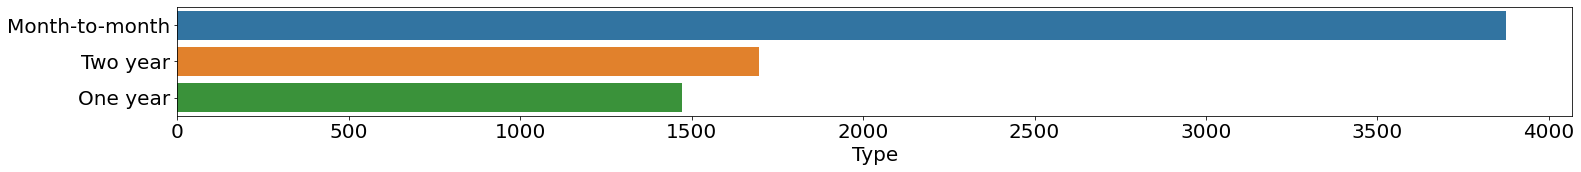

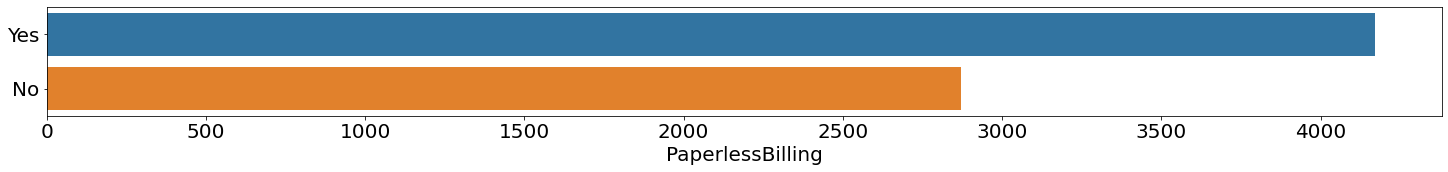

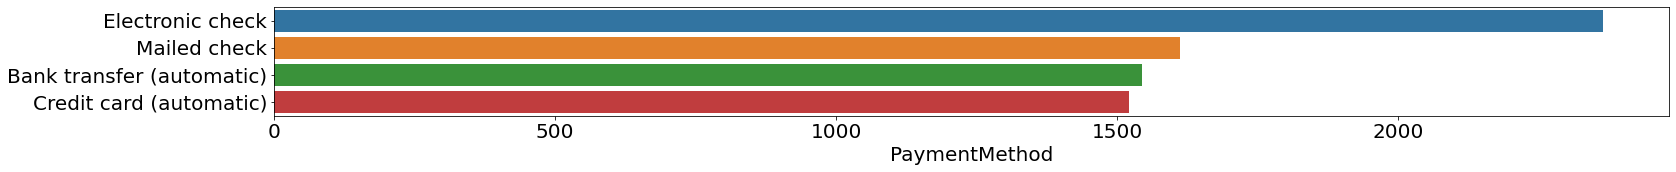

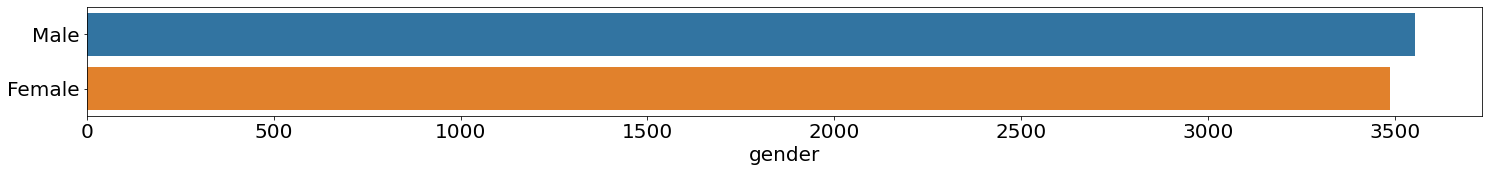

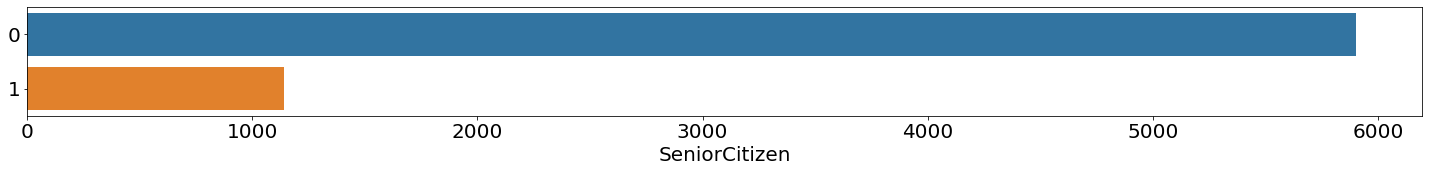

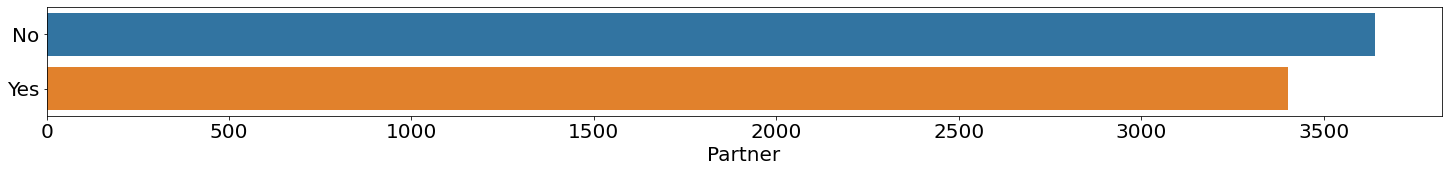

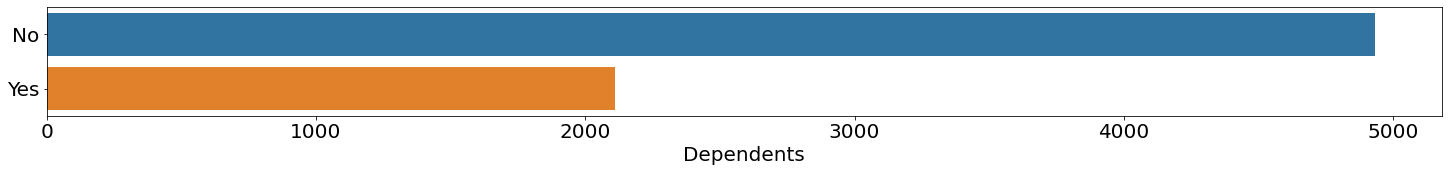

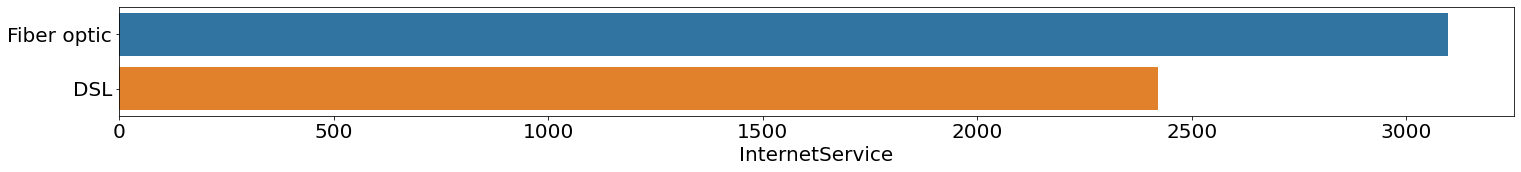

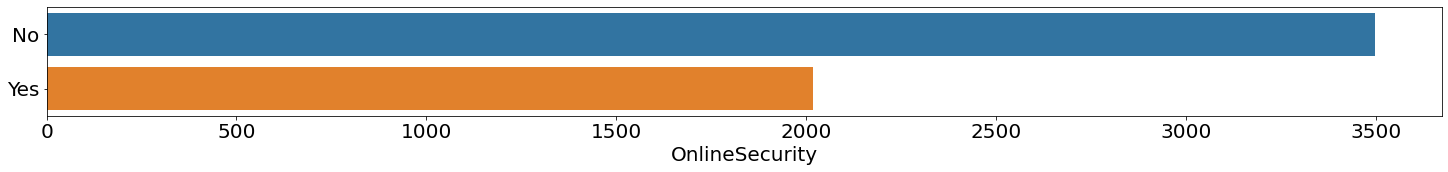

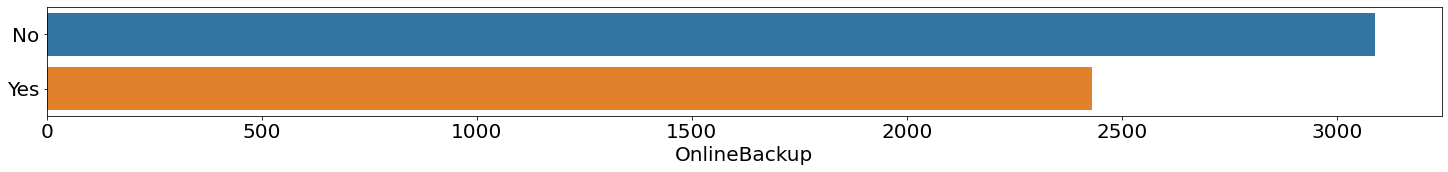

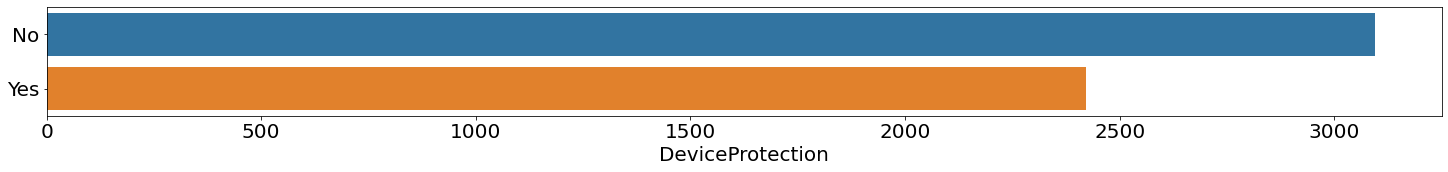

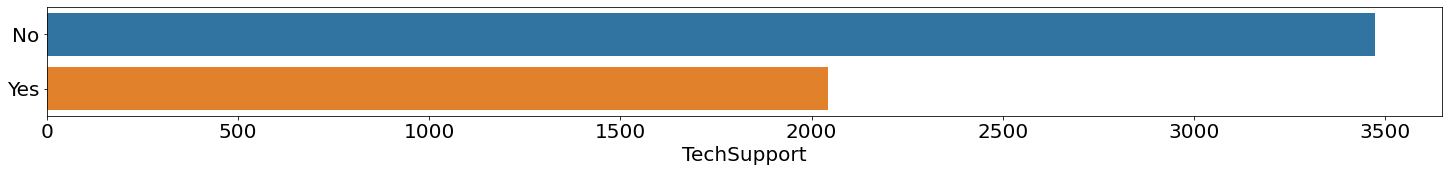

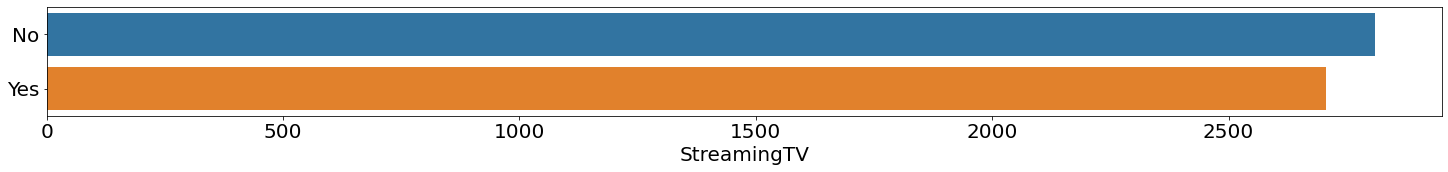

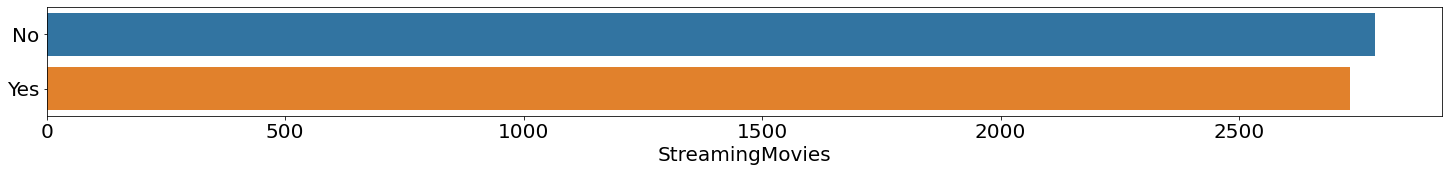

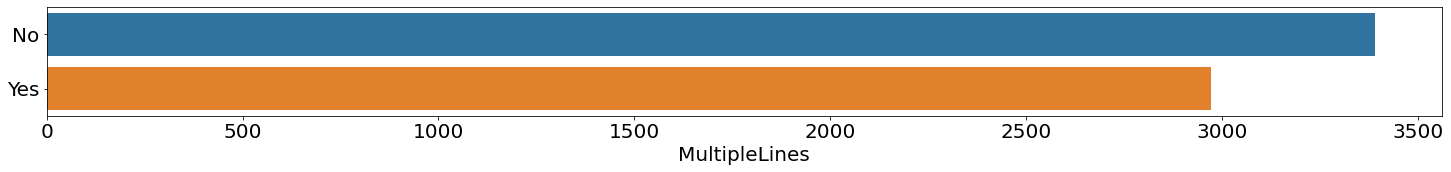

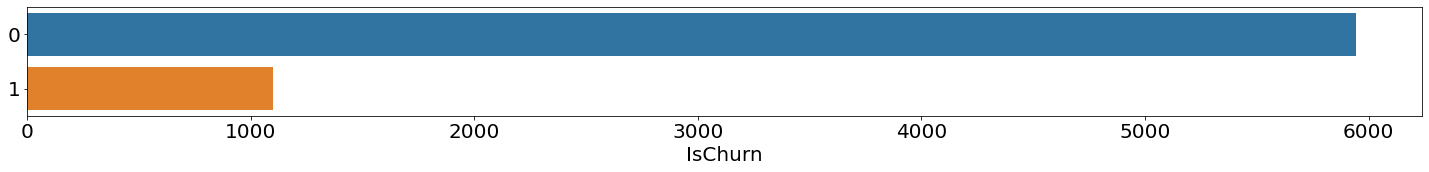

In [ ]:
for col in cat_feat:
    plot_cat_feat(df[col])

### Численные признаки

Столбец `TotalCharges` имеет не численный тип данных, исправили это:

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
display(df[df['TotalCharges'].isna()])
display(df[['MonthlyCharges', 'TotalCharges']].describe())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,IsChurn
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000


После изменения типа данных появились пропуски. Если взглянуть на столбец `BeginDate`, то можно понять, что это клиенты, которые подключились в последний месяц предоставленного периода.

Заполнили пропуски в `TotalCharges` значениями из столбца `MonthlyCharges`:

In [ ]:
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] =  df.loc[df['TotalCharges'].isna(), 'MonthlyCharges']
df[df['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,IsChurn


In [ ]:
def plot_num_feat(data, col_column):
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(12, 8))
    f.tight_layout()
    f.set_figheight(8)
    f.set_figwidth(12)
    plt.rcParams.update({'font.size': 18})

    for i, col in enumerate(col_column):
        sns.histplot(data[col], kde=True, bins=50, ax = ax[i, 0])
        sns.boxplot(data[col], ax = ax[i, 1])
        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количественных данных", fontsize=22, y=1.01)
    plt.show()

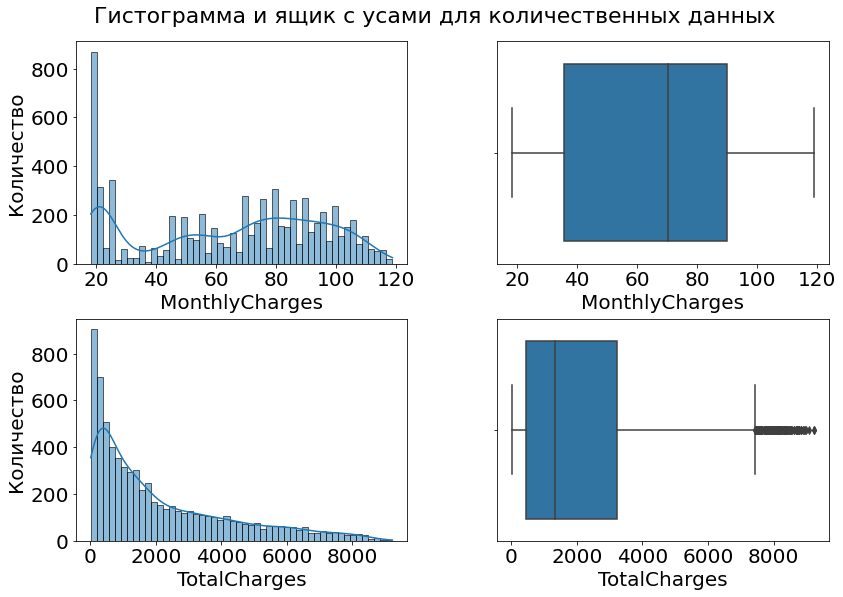

In [ ]:
num_features = df.select_dtypes(exclude=[object]).columns
num_features = num_features.drop(['SeniorCitizen', 'IsChurn'])

plot_num_feat(df, num_features)

### Выводы
- Большая часть клиентов (около половины) пользуется ежемесячной оплатой
- Клиенты, использующие электронные чеки, преобладают над клиентами, использующими бумажные квитанции
- Наиболее популярный способ оплаты - электронный чек
- Клиенты представлены в равной степени женщинами и мужчинами
- Доля клиентов пенсионного возраста очень мала
- Клиентов, состоящих в браке, примерно столько же, сколько и холостых/незамужних
- Клиентов без детей примерно в 2 раза больше, чем клиентов с детьми
- Большая часть клиентов пользуются оптоволокном
- Из дополнительных услуг интеренета около половины клиентов используют стриминговое телевидение и каталог фильмов, остальные услуги использует менее половины клиентов
- Дополнительную услугу телефонии (несколько линий) использует менее половины клиентов
- В представленном датасете доля ушедших клиентов весьма мала
- Распределение сумм ежемесячных оплат имеет 2 пика: первый в районе миинимума и второй в вблизи медианы.
- Распределение общей суммы оплат имеет нормальное распределение с положительным скосом вправо.

## Предобработка данных
В ходе знакомства с данными мы привели один из столбцов с количественным признаком к числовому типу данных.

Что ещё нужно сделать:
- Заполнить пропуски *No* в столбце `EndDate` последним месяцим представленного периода
- Исправить тип данных в столбцах с датами и рассчитать длительность контракта у каждого клиента
- Заполнить пропуски, появившиеся после слияния таблиц
- Изменить тип данных для бинарных признаков

In [ ]:
df.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
IsChurn               int64
dtype: object

### Даты
После введения целевого признака заменили значения '*Nо*' в стобеце `EndDate` на последний месяц.

После этого можно расчитали более показательный признак - длительность действия контракта для каждого клиента в днях:

In [ ]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
print('No' in sorted(df['EndDate'].unique()))

False


In [ ]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d', errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d', errors='coerce')

df['DaysContract'] = (df['EndDate'] - df['BeginDate']).dt.days
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,IsChurn,DaysContract
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


### Пропуски
Заполнили пропуски, появившиеся при слиянии. Значения `nan` в столбцах с доп. услугами заполнили на `No`, т.к. эти клиенты очевидно не пользуются этими услугами:

In [ ]:
df = df.fillna('No')
print('\nКоличество пропусков:\n', df.isna().sum())



Количество пропусков:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
IsChurn             0
DaysContract        0
dtype: int64


### Бинарные признаки

Привели бинарные признаки к единому виду и дали говорящие названия:

In [ ]:
binary_feat = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace([1, 0], ['Yes', 'No'])

In [ ]:
new_names_binary_feat = ['IsMale', 'IsSeniorCitizen', 'HasPartner', 'HasDependents', 'IsPaperlessBilling',
                  'BuyOnlineSecurity', 'BuyOnlineBackup', 'BuyDeviceProtection',
                   'BuyTechSupport', 'BuyStreamingTV', 'BuyStreamingMovies', 'BuyMultipleLines']
rename_dict = {binary_feat[i]: new_names_binary_feat[i] for i in range(12)}
print(len(binary_feat), len(new_names_binary_feat), rename_dict)

12 12 {'gender': 'IsMale', 'SeniorCitizen': 'IsSeniorCitizen', 'Partner': 'HasPartner', 'Dependents': 'HasDependents', 'PaperlessBilling': 'IsPaperlessBilling', 'OnlineSecurity': 'BuyOnlineSecurity', 'OnlineBackup': 'BuyOnlineBackup', 'DeviceProtection': 'BuyDeviceProtection', 'TechSupport': 'BuyTechSupport', 'StreamingTV': 'BuyStreamingTV', 'StreamingMovies': 'BuyStreamingMovies', 'MultipleLines': 'BuyMultipleLines'}


In [ ]:
df = df.rename(columns=rename_dict)
for col in df[new_names_binary_feat]:
    print(df[col].value_counts())

Male      3555
Female    3488
Name: IsMale, dtype: int64
No     5901
Yes    1142
Name: IsSeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: HasPartner, dtype: int64
No     4933
Yes    2110
Name: HasDependents, dtype: int64
Yes    4171
No     2872
Name: IsPaperlessBilling, dtype: int64
No     5024
Yes    2019
Name: BuyOnlineSecurity, dtype: int64
No     4614
Yes    2429
Name: BuyOnlineBackup, dtype: int64
No     4621
Yes    2422
Name: BuyDeviceProtection, dtype: int64
No     4999
Yes    2044
Name: BuyTechSupport, dtype: int64
No     4336
Yes    2707
Name: BuyStreamingTV, dtype: int64
No     4311
Yes    2732
Name: BuyStreamingMovies, dtype: int64
No     4072
Yes    2971
Name: BuyMultipleLines, dtype: int64


## Разведочный анализ данных
Посмотрели на баланс классов, рассмотрели распределения количественных и качественных признаков относительно целевого признака, добавили несколько синтетических признаков и проверили наличие корреляций:

### Распределение данных

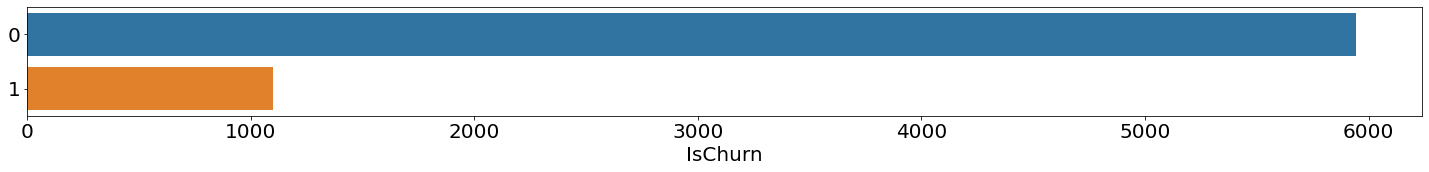

In [ ]:
plot_cat_feat(df['IsChurn'])

<div class="alert alert-block alert-success">
✔️ <b>Ревью 1</b>: Молодец, что обратил внимание на дисбаланс.
</div>

Наблюдается существенный дисбаланс классов: количество ушедших клиентов в несколько раз меньше, чем количество оставшихся.

In [ ]:
def plot_num_feat_2(data, col_column):
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(18, 12))
    f.tight_layout()
    f.set_figheight(12)
    f.set_figwidth(16)
    plt.rcParams.update({'font.size': 18})

    for i, col in enumerate(col_column):
        sns.histplot(data=df, x=col, hue='IsChurn', kde=True, bins=50, ax = ax[i, 0])
        sns.boxplot(data=df, y=col, x='IsChurn', ax = ax[i, 1])
        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
        ax[i, 1].set_ylabel(' ')

    plt.suptitle("Гистограмма и ящик с усами для количественных данных", fontsize=22, y=1.01)
    plt.show()

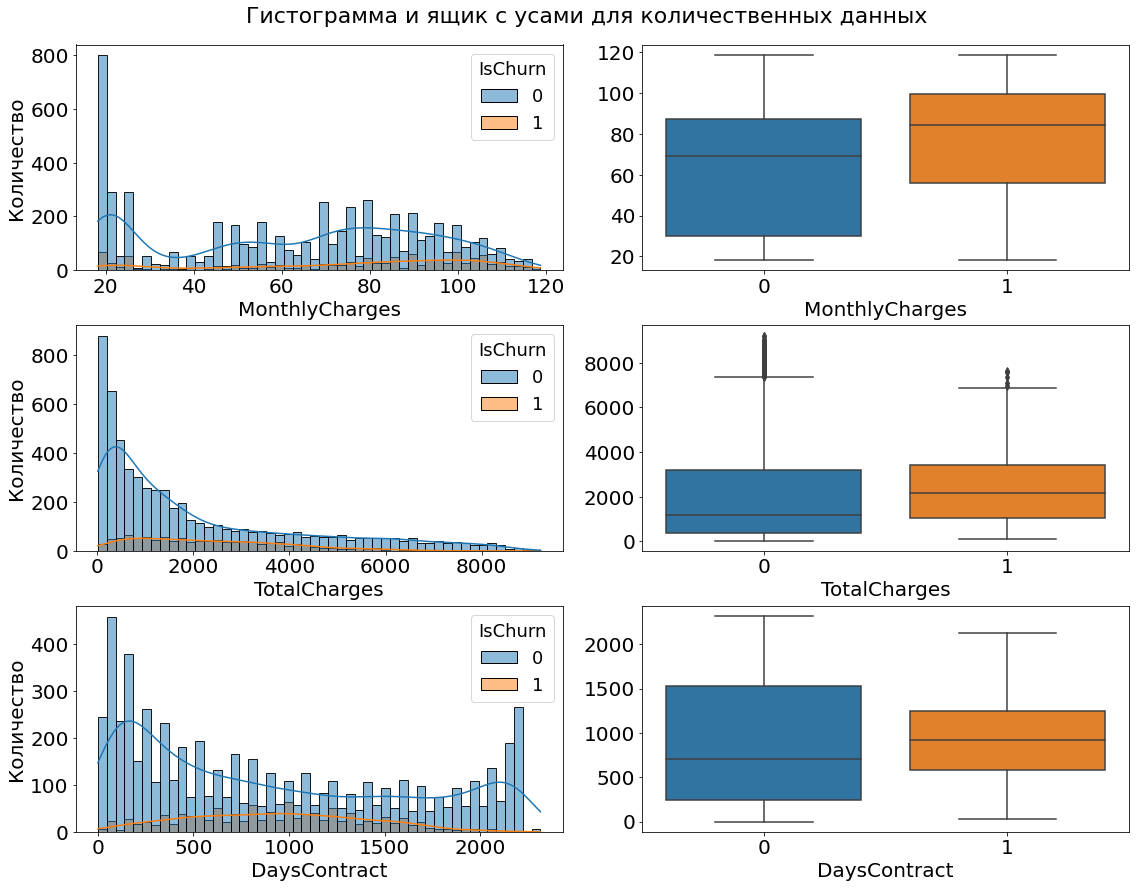

In [ ]:
df['DaysContract'] = df['DaysContract'].astype('float64')
num_features = df.select_dtypes(include=['float64']).columns
plot_num_feat_2(df, num_features)

По построенным графикам видно, что у ушедших клиентов преобладают пользователи с большой абоентской платой.

О распредлению суммарных говорить сложно так как ушедших клиентов мало, однако распределение как также скошено влево.

Среди остающихся клиентов есть пики длительности контракта, близкие к минимуму и близкие к максимуму - первый пик объяснеятсся большим притоком клиентов в последние месяцы, а второй пик носит информативный характер и говорит о тенденции постоянных клиентов к продолжению использования услуг. Распределение длительности ушедших клиентов подтверждает гипотезу - в области максимальных значений наблюдается провал.

In [ ]:
def cat_churn(df, cols, rotation=0):
    fig, ax = plt.subplots(1, len(cols), figsize=(22, 5))
    fig.tight_layout()
    fig.set_figheight(6)
    fig.set_figwidth(24)
    for i, col in enumerate(cols):
        sns.countplot(df[col], hue='IsChurn', data=df, ax=ax[i])
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)


In [ ]:
df.dtypes

customerID                     object
BeginDate              datetime64[ns]
EndDate                datetime64[ns]
Type                           object
IsPaperlessBilling             object
PaymentMethod                  object
MonthlyCharges                float64
TotalCharges                  float64
IsMale                         object
IsSeniorCitizen                object
HasPartner                     object
HasDependents                  object
InternetService                object
BuyOnlineSecurity              object
BuyOnlineBackup                object
BuyDeviceProtection            object
BuyTechSupport                 object
BuyStreamingTV                 object
BuyStreamingMovies             object
BuyMultipleLines               object
IsChurn                         int64
DaysContract                  float64
dtype: object

In [ ]:
obj_features = ['Type', 'PaymentMethod','InternetService']
obj_features

['Type', 'PaymentMethod', 'InternetService']

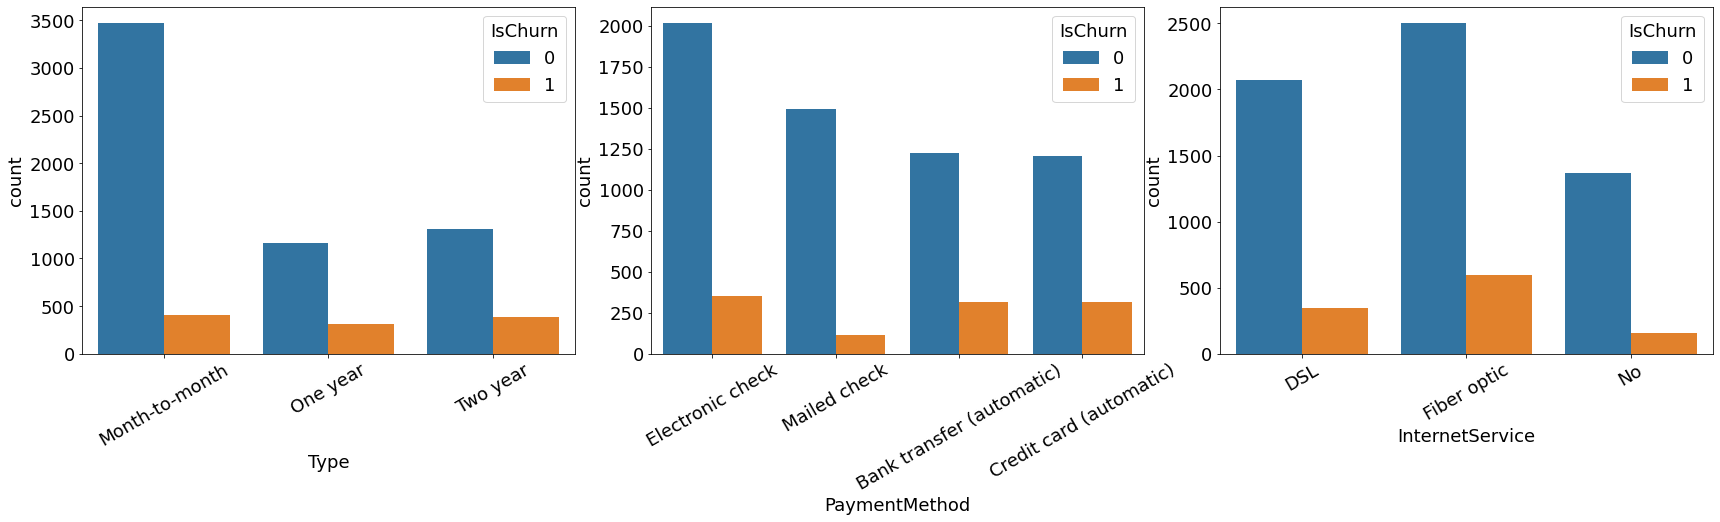

In [ ]:
cat_churn(df, obj_features, rotation=30)

In [ ]:
bin_features = df.select_dtypes(include=['object']).columns
bin_features = bin_features.drop(['customerID','Type', 'PaymentMethod','InternetService'])
len(bin_features)

12

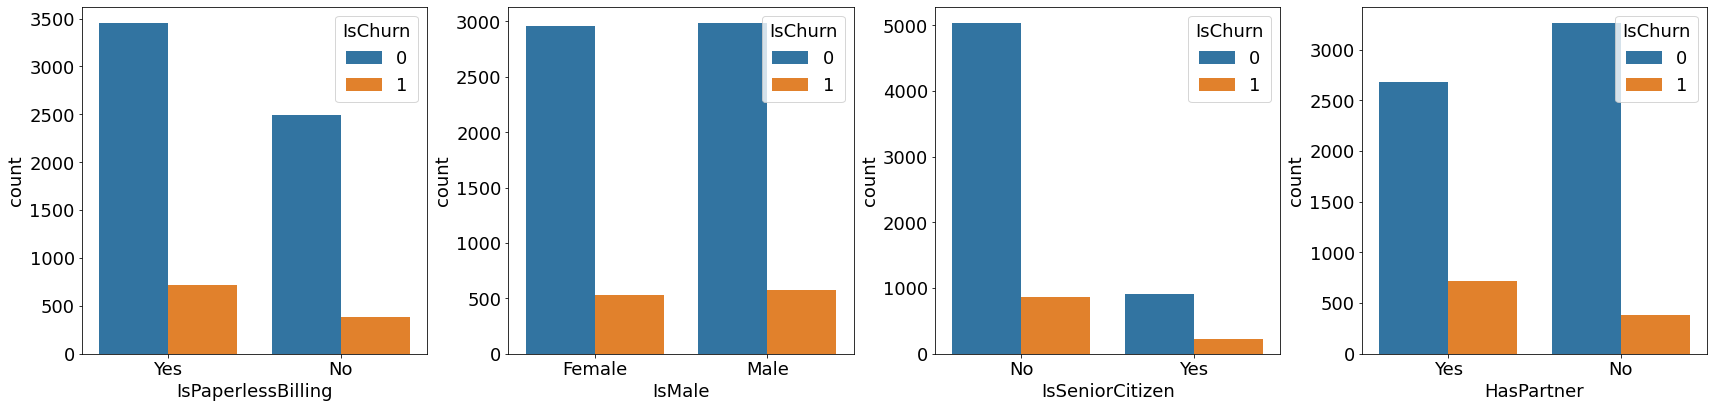

In [ ]:
cat_churn(df, bin_features[:4])

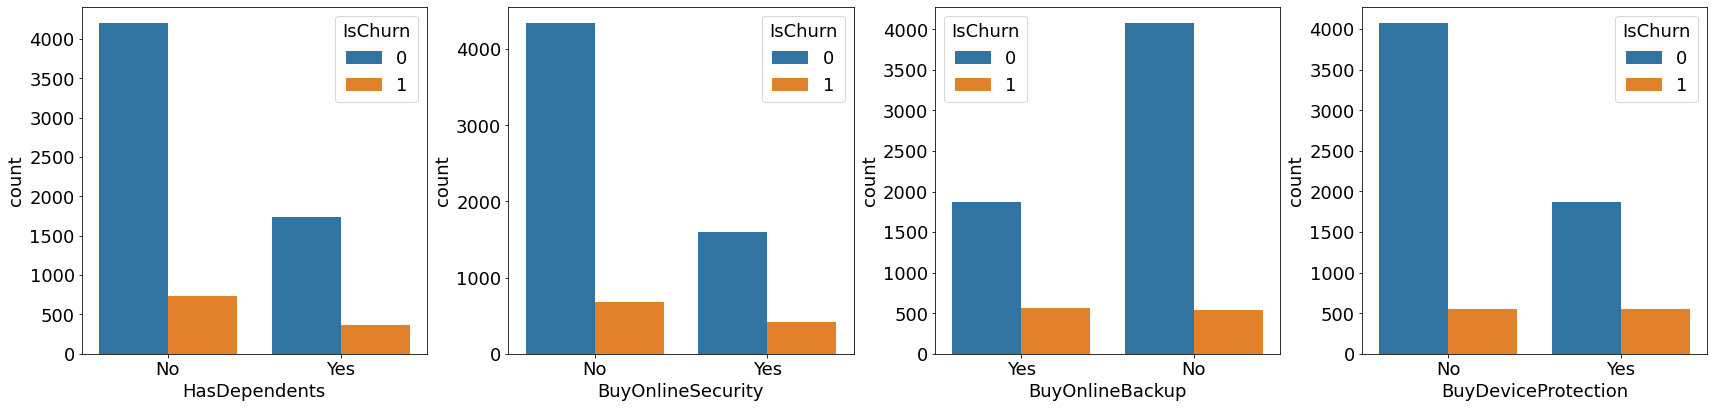

In [ ]:
cat_churn(df, bin_features[4:8])

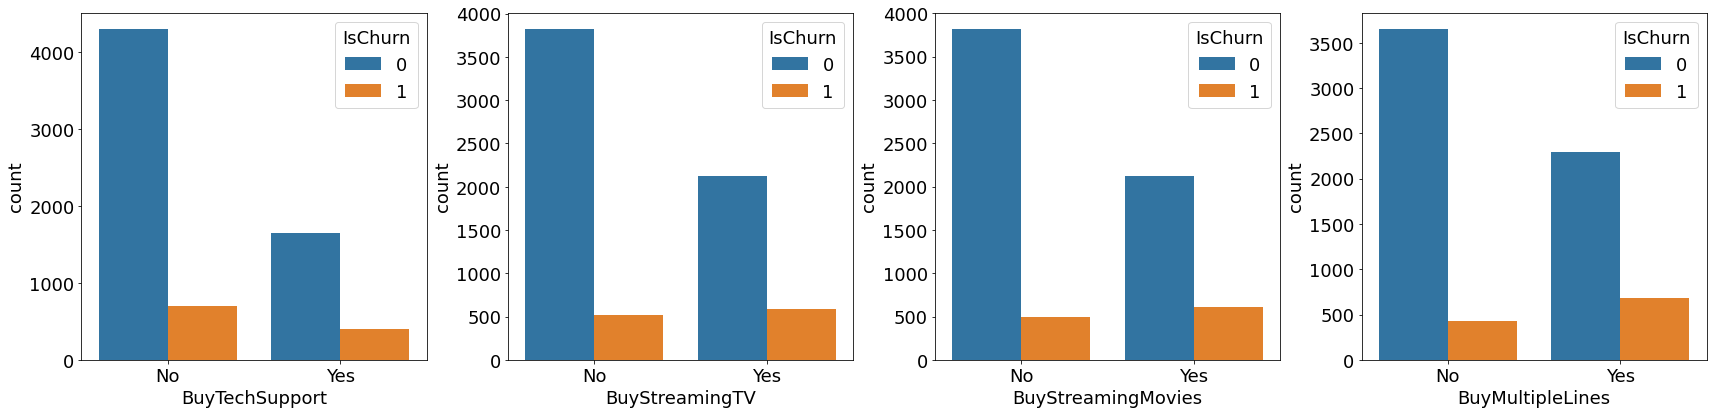

In [ ]:
cat_churn(df, bin_features[8:])

По построенным графика видно, что в по некоторым признакам разницы в классах по целевому признаку нету, в основном, количество ушедших меньше, но внутри классов распределение примерно одинаковое: `IsSeniorCitizen`, `HasDependents`
Однако, в признаках, дополнительных услуг наблюдается увеличенная доля ушедших клиентов, которые приебрели дополнительную услугу: `BuyOnlineBackup`, `BuyDeviceProtection` и проч. Также фактор наличия партнера увеличивает долю ушедших клиентов `HasPartner`.

Далее добавили синтетические признаки:
- *Покупатели на перспективу*: клиенты выбирающие тип оплаты раз в год или два года
- *Новички*: клиенты, длительность контракта которых 3 месяца и менее
- *Бывалые*: клиенты, длительность контракта которых 1 год и более
- *Киты интернета*: клиенты покупающие как минимум 4 из 6 доп.услуг

### Новые признаки и корреляция

In [ ]:
print(df.columns)
extra_services = list(df.columns[13:-3])
print(extra_services)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'IsPaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'IsMale',
       'IsSeniorCitizen', 'HasPartner', 'HasDependents', 'InternetService',
       'BuyOnlineSecurity', 'BuyOnlineBackup', 'BuyDeviceProtection',
       'BuyTechSupport', 'BuyStreamingTV', 'BuyStreamingMovies',
       'BuyMultipleLines', 'IsChurn', 'DaysContract'],
      dtype='object')
['BuyOnlineSecurity', 'BuyOnlineBackup', 'BuyDeviceProtection', 'BuyTechSupport', 'BuyStreamingTV', 'BuyStreamingMovies']


In [ ]:
extra_services = list(df.columns[13:-3])
df['IsPerspective'] = ((df['Type'] == 'One year') | (df['Type'] == 'Two year'))
df['IsNew'] = (df['DaysContract'] <= 91)
df['IsOld'] = (df['DaysContract'] >= 365)
df['IsWhale'] = (df[extra_services].replace(['Yes', 'No'], [1, 0]).sum(axis=1) >= 4)
df[['IsWhale','IsNew','IsOld','IsPerspective']].sample(5)

,IsWhale,IsNew,IsOld,IsPerspective
6592,False,False,True,True
6383,False,False,True,True
5231,False,False,True,False
4169,True,False,True,False
3165,False,False,True,True


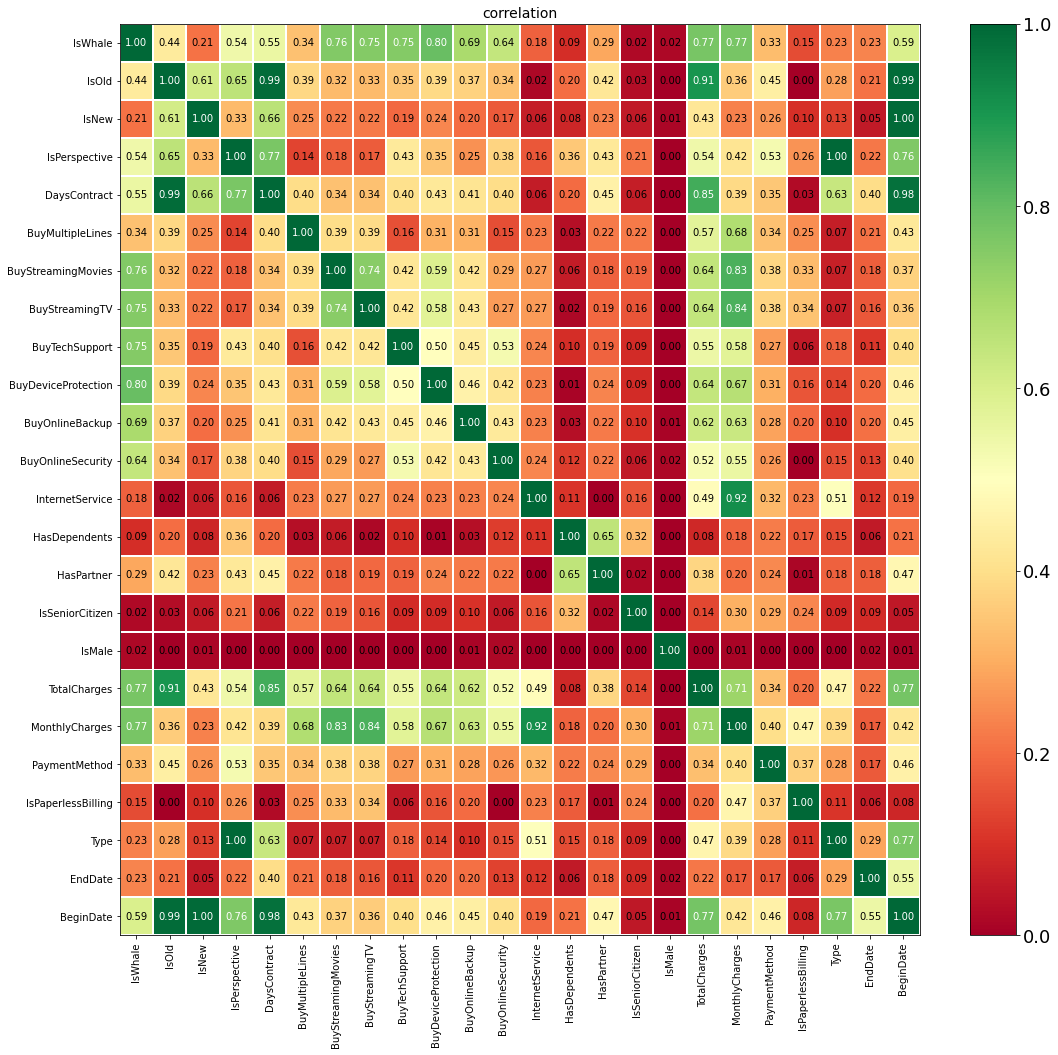

In [ ]:
df_corr = df.drop(['IsChurn','customerID'], axis=1)
phik_corr = df_corr.phik_matrix(interval_cols=num_features)

plot_correlation_matrix(phik_corr.values,
                        x_labels=phik_corr.columns,
                        y_labels=phik_corr.index,
                        vmin=0, vmax=1,
                        figsize=(16, 15))
plt.tight_layout()

Выводы по корреляции:
- Признаки с наименьшей корреляцией
    - `IsMale`
    - `HasDependents`    
    - `IsSeniorCitizen`    
- Признаки с наибольшей корреляцией
    - `TotalCharges`    
    - `MonthlyCharges`    
    - `IsWhale`    

## Выбор модели

### Подготовка признаков
Удалим признаки:
- `BeginDate` и `EndDate`, вместо которых был введен признак `DaysContract`
- `IsMale` и `customerID` - не имеет ценности

In [ ]:
df.drop(columns=['BeginDate', 'EndDate' ,'customerID', 'IsMale'], inplace=True)
df.dtypes

Type                    object
IsPaperlessBilling      object
PaymentMethod           object
MonthlyCharges         float64
TotalCharges           float64
IsSeniorCitizen         object
HasPartner              object
HasDependents           object
InternetService         object
BuyOnlineSecurity       object
BuyOnlineBackup         object
BuyDeviceProtection     object
BuyTechSupport          object
BuyStreamingTV          object
BuyStreamingMovies      object
BuyMultipleLines        object
IsChurn                  int64
DaysContract           float64
IsPerspective             bool
IsNew                     bool
IsOld                     bool
IsWhale                   bool
dtype: object

### Разделение на выбороки и масштабирование

In [ ]:
X = df.drop('IsChurn', axis=1)
y = df['IsChurn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RS)
print(X_train.shape, y_train.shape)
print(X_train.shape, y_test.shape)

(5282, 21) (5282,)
(5282, 21) (1761,)


In [ ]:
print(num_feat)
num_feat.append('DaysContract')
print(num_feat)
display(X_train[num_feat].describe())

['MonthlyCharges', 'TotalCharges']
['MonthlyCharges', 'TotalCharges', 'DaysContract']


,MonthlyCharges,TotalCharges,DaysContract
count,5282.000000,5282.000000,5282.000000
mean,65.035782,2116.028684,895.955699
std,29.895821,2109.194601,681.818861
min,18.250000,19.050000,0.000000
25%,36.912500,427.692500,276.000000
50%,70.450000,1356.075000,761.000000
75%,89.887500,3260.865000,1461.000000
max,118.650000,9221.380000,2314.000000


In [ ]:
cat_feat = df.select_dtypes(include=['object', 'bool']).columns
cat_feat

Index(['Type', 'IsPaperlessBilling', 'PaymentMethod', 'IsSeniorCitizen',
       'HasPartner', 'HasDependents', 'InternetService', 'BuyOnlineSecurity',
       'BuyOnlineBackup', 'BuyDeviceProtection', 'BuyTechSupport',
       'BuyStreamingTV', 'BuyStreamingMovies', 'BuyMultipleLines',
       'IsPerspective', 'IsNew', 'IsOld', 'IsWhale'],
      dtype='object')

### Подбор моделей

In [ ]:
analisys = pd.DataFrame({'model':[], 'AUC':[], 'time_to_predict':[]})
all_models = []

def fit_report(grid, model_name):
    print(f'Параметры модели: {grid.estimator}')
    print(f'Вариантов модели: {len(grid.cv_results_["params"])}')
    print(f'Лучший AUC: {grid.best_score_}')

    row = []
    row.extend([model_name, grid.best_score_, grid.cv_results_['mean_fit_time'].mean()])
    analisys.loc[len(analisys.index)] = row


#### Логистическая регрессия

In [ ]:
%%time
pipe = Pipeline([
    ('ohe', ColumnTransformer(
        transformers=[('ohe', OneHotEncoder(sparse=False, drop='first'), cat_feat), ('slr', StandardScaler(), num_feat)],
        remainder='passthrough')),
    ('clf', LogisticRegression(random_state=RS, max_iter=500))
])
params = {'clf__solver': ['lbfgs', 'liblinear'],
          'clf__class_weight' : [None, 'balanced']}

log_grid = GridSearchCV(pipe, params,
                        scoring='roc_auc',
                        return_train_score=True,
                        cv=4,
                        n_jobs=-1)

log_grid.fit(X_train, y_train)
fit_report(log_grid, 'LogRegress')

Параметры модели: Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  Index(['Type', 'IsPaperlessBilling', 'PaymentMethod', 'IsSeniorCitizen',
       'HasPartner', 'HasDependents', 'InternetService', 'BuyOnlineSecurity',
       'BuyOnlineBackup', 'BuyDeviceProtection', 'BuyTechSupport',
       'BuyStreamingTV', 'BuyStreamingMovies', 'BuyMultipleLines',
       'IsPerspective', 'IsNew', 'IsOld', 'IsWhale'],
      dtype='object')),
                                                 ('slr', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'DaysCont

#### Случайный лес

In [ ]:
%%time
pipe = Pipeline([
    ('odi', ColumnTransformer(
        transformers=[('odi', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value = -1), cat_feat),
                      ('slr', StandardScaler(), num_feat)],
        remainder='passthrough')),
    ('clf', RandomForestClassifier(random_state=RS))
])
params = {'clf__max_depth': range(4, 21, 4),
          'clf__min_samples_leaf': range(1, 11, 1),
          'clf__n_estimators': [10, 50, 100],
          'clf__class_weight' : [None, 'balanced']}

forest_grid = RandomizedSearchCV(pipe, params,
                        scoring='roc_auc',
                        cv=4,
                        n_jobs=-1)

forest_grid.fit(X_train, y_train)
fit_report(forest_grid, 'RandForest')

Параметры модели: Pipeline(steps=[('odi',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('odi',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Type', 'IsPaperlessBilling', 'PaymentMethod', 'IsSeniorCitizen',
       'HasPartner', 'HasDependents', 'InternetService', 'BuyOnlineSecurity',
       'BuyOnlineBackup', 'BuyDeviceProtection', 'BuyTechSupport',
       'BuyStreamingTV', 'BuyStreamingMovies', 'BuyMultipleLines',
       'IsPerspective', 'IsNew', 'IsOld', 'IsWhale'],
      dtype='object')),
                                                 ('slr', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                

#### LGBMClassifier

In [ ]:
%%time
pipe = Pipeline([
    ('odi', ColumnTransformer(
        transformers=[('odi', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value = np.nan), cat_feat), ('slr', StandardScaler(), num_feat)],
        verbose_feature_names_out=False, remainder='passthrough')),
    ('clf', LGBMClassifier(random_state=RS))
])
params = {'clf__learning_rate': [.001, .01, 0.1],
          'clf__n_estimators': [100, 300, 500],
          'clf__num_leaves': [25, 75, 125, 175],
          'clf__class_weight': [None, 'balanced']}

lgbm_grid = RandomizedSearchCV(pipe, params,
                        scoring='roc_auc',
                        cv=4,
                        n_jobs=-1,
                        random_state=RS)

lgbm_grid.fit(X_train, y_train)
fit_report(lgbm_grid, 'LGBM')

Параметры модели: Pipeline(steps=[('odi',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('odi',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  Index(['Type', 'IsPaperlessBilling', 'PaymentMethod', 'IsSeniorCitizen',
       'HasPartner', 'HasDependents', 'InternetService', 'BuyOnlineSecurity',
       'BuyOnlineBackup', 'BuyDeviceProtection', 'BuyTechSupport',
       'BuyStreamingTV', 'BuyStreamingMovies', 'BuyMultipleLines',
       'IsPerspective', 'IsNew', 'IsOld', 'IsWhale'],
      dtype='object')),
                                                 ('slr', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                               

### Тестирование лучшей модели

In [ ]:
lgbm_pred_prob = lgbm_grid.predict_proba(X_test)[:, 1]
print(f'ROC_AUC модели LGBM на тестовой выборке: {roc_auc_score(y_test, lgbm_pred_prob)}')

ROC_AUC модели LGBM на тестовой выборке: 0.8961482931604063


### График ROC-кривой и accuracy

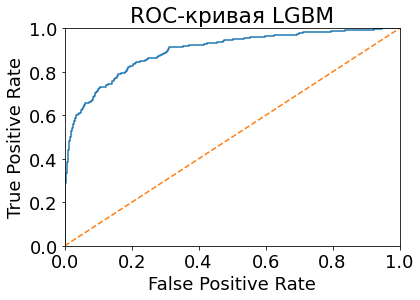

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=lgbm_pred_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая LGBM')
plt.show()

По графику видно, что площадь под графиком кривой весьма велика, что соответствует большому значению ROC_AUC полученному ранее на тестовой выборке. TPR - доля правильно предсказанных ушедших клиентов от общего числа ушедших клиентов, а FPR - доля неправильно предсказанных ушедших клиентов от общего числа неушедших клиентов. Идеальная модель даст картину углообразного графика, проходящего через точку 0,1. Наша модель близка к этому результату.

In [ ]:
lgbm_pred = lgbm_grid.predict(X_test)
print('Accuracy LGBM на тестовой выборке:', accuracy_score(y_test, lgbm_pred).round(2))

Accuracy LGBM на тестовой выборке: 0.91


### Матрица ошибок

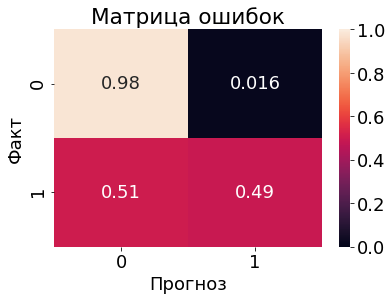

In [ ]:
matrix = confusion_matrix(y_test, lgbm_pred, normalize='true')
sns.heatmap(pd.DataFrame(matrix), annot=True, vmin=0, vmax=1)
plt.xlabel('Прогноз')
plt.ylabel('Факт')
plt.title('Матрица ошибок')
plt.show()

### Важность признаков

In [ ]:
feat_importances = lgbm_grid.best_estimator_.steps[1][1].feature_importances_
model = lgbm_grid.best_estimator_.fit(X_train, y_train)
feat_names = model[:-1].get_feature_names_out()
feat_importance = pd.Series(feat_importances,
                               index=feat_names)

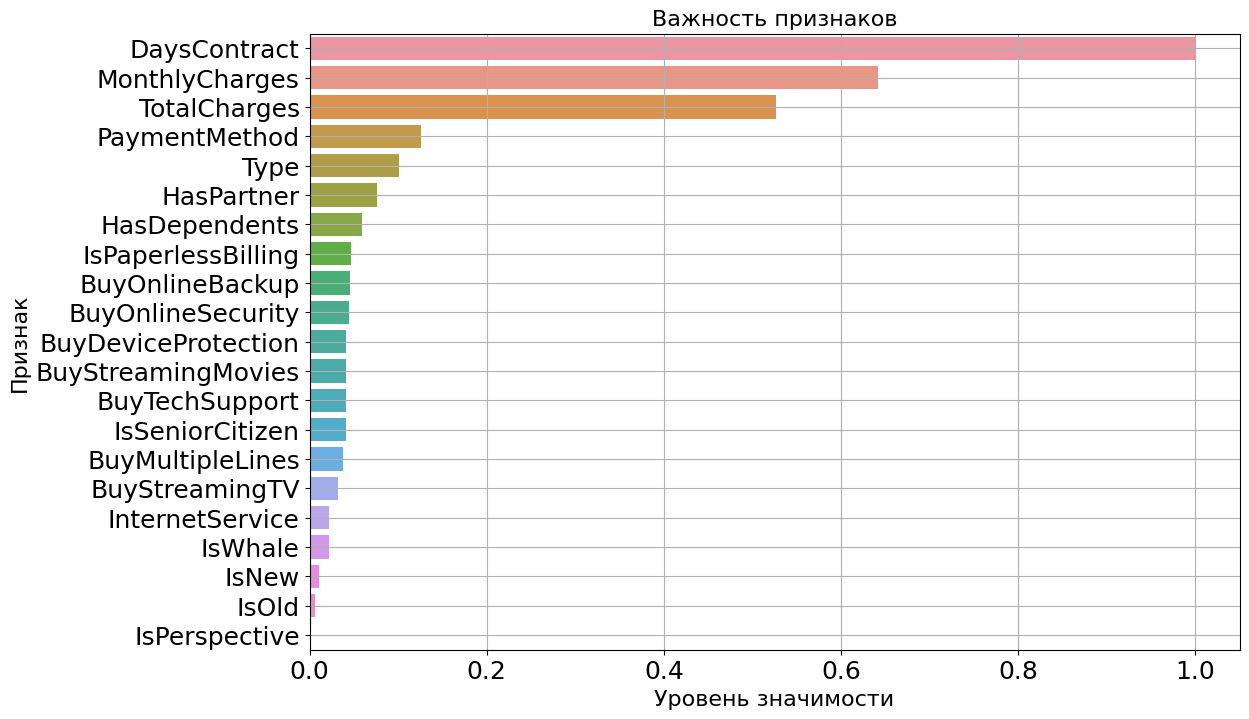

In [ ]:
feat_importance = (feat_importance/feat_importance.max()).sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title('Важность признаков', fontsize=16)
plt.xlabel('Уровень значимости', fontsize=16)
plt.ylabel('Признак', fontsize=16)
plt.grid()
plt.show()

## Отчет

В ходе выполнения проекта:
- Ознакомились с данными
    - Объединили предоставленные таблицы
    - Привели значения к нужному типу данных и заполнили пропуски
    - Посмотрели на распределение количественных и качественных признаков
    - Добавили признак длительности контракта клиента и целевой признак - ушел клиент или нет
- Провели разведочный анализ
    - Посмотрели на распределение количественных и качественных признаков относительно целевого признака
    - Добавлены новые признаки на основе существующих
    - Построена и исследована матрица корреляции для всех признаков (кроме целевого)
- Выбрали наиболее подходящую модель
    - Разибили данные на обучающую и тестовую выборки
    - Построили модель Логистической регрессии
    - Построили модель Случайного леса
    - Построили модель LGBM
- Протестировали лучшую модель
    - Расчитатли ROC_AUC для выбранной модели
    - Рассчитали Accuracy и построили ROC-кривую для выбранной модели
    - Построили матрицу ошибок для выбранной модели
    - Проанализировали важность признаков

Все шаги были выполнены в соответствии с расписанным ранее планом.

Высокого показателя ROC_AUC помогло достичь исключение наименее полезных для модели признаков из обучения. Также помогло использование конвееров, которое исключило утечку данных из валидационных фолдов при кросс-валидации.

При обучении были использованы все изначальные признаки кроме `BeginDate`, `EndDate` ,`customerID`, `IsMale`, причем первые два были заменены одним более показательным признаком. Также использовались дополнительно введенные признаки, основанные на изначальных, однако их важность оказалась мала.

Полученные пропуски в столбце `TotalCharges` были заполнены значениями из столбца `MonthlyCharges`, т.к. пропуски имели клиенты пришедшие в последний месяц и, видимо, ещё не успевшие сделать ни одной оплаты.

### В конечном счёте была выбрана модели LGBMClassifier
обученная на представленной сетке параметров:
         
        {'clf__learning_rate': [.001, .01, 0.1],
         'clf__n_estimators': [100, 300, 500],
         'clf__num_leaves': [25, 75, 125, 175],
         'clf__class_weight': [None, 'balanced']}

На выбранной модели были получены следующие значения метрики :

**ROC_AUC = 0.896,
Accuracy = 0.91**
         
Анализ важности признаков показал, что наиболее важным признаком оказалось длительность контракта клиента. Также важными признаками являются сумма ежемесячной оплаты и общая сумма оплаты.

Трудности, встреченные по ходу выполнения проекта:
- Выбор признаков для обучения моделей. Вопрос о полезности синтетических признаков и набора изначальных признаков требует дальнейшего изучения.
- Настройка модели для увеличения доли истинно-положительных предсказаний.

Для улучшения модели в дальнейшем предлагаем:
- Подобрать порог классификации для работы модели, чтобы лучше предсказывать уйдёт клиент или нет.
- Собирать исторические данные по использованию телеком-услугами клиентов. Наиболее важным признаком для обучения модели стала длительность контракта клиента, поэтому данные о длительности пользования другими телеком-услугами могли бы улучшить точность предсказаний.
- Собирать данные о финансовом состоянии клиентов. Важными признаками оказались суммы оплаты услуг, поэтому, возможно, данные о финансовом состоянии клиентов или их финансовых ожиданиях/предпочтениях могли бы помочь модели делать более точные предсказания.